In [668]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [669]:
df_2024 = pd.read_parquet(r"C:\Users\Guest_Account\Desktop\Futures Strategies\Futures_2024.parquet", engine='pyarrow')
df_2023 = pd.read_parquet(r"C:\Users\Guest_Account\Desktop\Futures Strategies\Futures_2023.parquet", engine='pyarrow')

In [670]:
df = pd.concat([df_2023, df_2024])
df = df[[col for col in df.columns if 'Close' in col]]
price = df['AUROPHARMA_Close']
prices = price.to_frame(name=' AUROPHARMA Price')
prices.index = pd.to_datetime(prices.index)
prices.index.name = 'Datetime'
prices = prices.resample('30T', origin = '2023-01-02 09:15:00').last()
prices.dropna(inplace=True)

C:\Users\Guest_Account\AppData\Local\Temp\ipykernel_28120\975647947.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  prices = prices.resample('30T', origin = '2023-01-02 09:15:00').last()


In [671]:
def calculate_returns_and_std_dev(prices):
        returns = (prices.diff() / prices.shift(1)) *100
        sd_returns_s = returns.ewm(span = 32).std()
        sd_returns_l = returns.ewm(span = 700).std()
        sd_returns = 0.3*sd_returns_l + 0.7*sd_returns_s
        sd_returns.index = prices.index
        
        return sd_returns*110

In [672]:
prices

,AUROPHARMA Price
Datetime,
2023-01-02 09:15:00,432.95
2023-01-02 09:45:00,433.00
2023-01-02 10:15:00,434.00
2023-01-02 10:45:00,433.80
2023-01-02 11:15:00,433.80
...,...
2024-07-02 13:15:00,1216.10
2024-07-02 13:45:00,1216.15
2024-07-02 14:15:00,1218.10


In [673]:
sd = calculate_returns_and_std_dev(prices)
sd.iloc[2]

AUROPHARMA Price    17.065175
Name: 2023-01-02 10:15:00, dtype: float64

In [674]:
def calculate_ewma_signals(prices):
        ewma_16 = prices.ewm(span=16).mean()
        ewma_64 = prices.ewm(span=64).mean()
        ewma_16.index = prices.index
        ewma_64.index = prices.index
        return ewma_16, ewma_64

In [675]:
for timestamp in prices.index:

        def capped_forecast(prices):
                ewma_16, ewma_64 = calculate_ewma_signals(prices)
                sd = calculate_returns_and_std_dev(prices)
                sigma_p = (prices * sd)/ 1600

                raw_forecast = (ewma_16 - ewma_64) / (sigma_p)

                scaled_forecast = 4.1 * raw_forecast 

                return scaled_forecast


In [676]:
cf = capped_forecast(prices)

In [677]:
abs(cf).mean()

AUROPHARMA Price    1.259115
dtype: float64

In [678]:
ewma_16 , ewma_64 = calculate_ewma_signals(prices)

In [679]:
(ewma_16 - ewma_64).describe()

,AUROPHARMA Price
count,4787.000000
mean,3.887753
std,11.579127
min,-44.045257
25%,-2.292791
50%,3.044904
75%,10.779766
max,37.542728


In [680]:
#Plan:
#Difference now is we need to use a faster trend (16, 64)
#Also, need a raw forecast function and scaled forecast
#Then change N accordingly
#Add Buffer


class FutureStrategyTwo:
    def __init__(self, price, initial_capital= 1000000, target_risk = 20):
        self.prices = prices
        self.mult = 550 #Found in other doc
        self.cash = initial_capital 
        self.targetrisk = target_risk #%, as found in book.
        self.position = 4
        self.trade_log = []
        self.capital_series = pd.Series(index=prices.index)
        self.capital_series.iloc[1] = initial_capital
        self.position_series = pd.Series(index=prices.index)
       


        self.sd_returns = self.calculate_returns_and_std_dev()
        self.ewma_16, self.ewma_64 = self.calculate_ewma_signals()
        



    def calculate_returns_and_std_dev(self):
        returns = (self.prices.diff() / self.prices.shift(1)) *100
        sd_returns_s = returns.ewm(span = 32).std()
        sd_returns_l = returns.ewm(span = 700).std()
        sd_returns = 0.3*sd_returns_l + 0.7*sd_returns_s
        sd_returns.index = self.prices.index
        
        return sd_returns*110
    
    def calculate_ewma_signals(self):
        ewma_16 = self.prices.ewm(span=16).mean()
        ewma_64 = self.prices.ewm(span=64).mean()
        ewma_16.index = self.prices.index
        ewma_64.index = self.prices.index
        return ewma_16, ewma_64
        
    def capped_forecast_series(self,timestamp):
        price =  self.prices
        s_d = self.sd_returns
        sigma_p = (price * s_d)/ 1600

        raw_forecast = (self.ewma_16 - self.ewma_64) / (sigma_p)

        avg_raw = abs(raw_forecast).mean()

        capped_forecast = 10 * raw_forecast/avg_raw

        cap_forecast = pd.Series(index = prices.index)
        cap_forecast[timestamp] = max(min(capped_forecast[timestamp], 20), -20)


        return capped_forecast

        
    def calculate_N(self, timestamp):
        price = self.prices.loc[timestamp]
        cap_forecast_series = self.capped_forecast_series(timestamp)
        num_of_contracts = (cap_forecast_series.loc[timestamp] * self.cash * self.targetrisk) / (10 *price * self.mult * self.sd_returns.loc[timestamp])
 
        return int(num_of_contracts)   

    def buy_contract(self, timestamp, contracts):
        price = self.prices.loc[timestamp]
        self.position += contracts
        self.cash -= contracts * price * self.mult
        self.trade_log.append((timestamp, 'BUY', contracts, price))
        self.capital_series[timestamp] = self.capital_series.shift(1).loc[timestamp] + (price - self.prices.shift(1).loc[timestamp])*self.position*self.mult
        self.position_series[timestamp] = self.position

    def sell_contract(self, timestamp, contracts):
        price = self.prices.loc[timestamp]
        self.position -= contracts
        self.cash += contracts * price * self.mult
        self.trade_log.append((timestamp, 'SELL', contracts, price))
        self.capital_series[timestamp] = self.capital_series.shift(1).loc[timestamp] + (price - self.prices.shift(1).loc[timestamp])*self.position*self.mult
        self.position_series[timestamp] = self.position
    
    def no_trade(self, timestamp, contracts):
        price = self.prices.loc[timestamp]
        self.position += contracts
        self.cash -= contracts * price * self.mult
        self.trade_log.append((timestamp, 'HOLD POSITION', price))
        self.capital_series[timestamp] = self.capital_series.shift(1).loc[timestamp] + (price - self.prices.shift(1).loc[timestamp])*self.position*self.mult
        self.position_series[timestamp] = self.position

    def buffer_region(self, timestamp):
        price = self.prices.loc[timestamp].values
        f = 0.1
        buffer_value = (f * self.cash * self.targetrisk) / (self.mult * price * self.sd_returns.loc[timestamp].values)

        n = self.calculate_N(timestamp)

        lower_buffer = int(n - buffer_value)
        upper_buffer = int(n + buffer_value)
        
        return lower_buffer, upper_buffer


    def trade(self, timestamp):
    
        num_of_contracts =  self.calculate_N(timestamp)

        lower_buffer, upper_buffer = self.buffer_region(timestamp)

        if lower_buffer <= self.position <= upper_buffer:
            self.no_trade(timestamp, 0)

        elif self.position < lower_buffer:
            self.buy_contract(timestamp, lower_buffer - self.position)
        
        elif self.position > upper_buffer:
            self.sell_contract(timestamp, self.position - upper_buffer)

        

        #if num_of_contracts> 0:
            #contracts_to_trade = num_of_contracts - self.position
        #elif num_of_contracts< 0:
            #contracts_to_trade = self.position - num_of_contracts
        #else:
            #contracts_to_trade = -self.position


        #if (contracts_to_trade > 0) : 
            #self.buy_contract(timestamp, contracts_to_trade)

        #elif (contracts_to_trade < 0):
            #self.sell_contract(timestamp, -(contracts_to_trade))
        
        #else:
            #self.no_trade(timestamp, 0) 

        
    def get_capital_progression(self):
        return self.capital_series

    def get_trade_log(self):
        return self.trade_log
    
    def get_position_series(self):
        return self.position_series
    
strategy = FutureStrategyTwo(prices)



for timestamp in prices.index[2:]:  
    strategy.trade(timestamp)

cap_progression = strategy.get_capital_progression()[1:]
print("Capital Progression Over Time:")
print(cap_progression)

trade_log = strategy.get_trade_log()
print("Trade Log:")
print(trade_log)

position_series = strategy.get_position_series()


KeyError: Timestamp('2023-01-02 10:15:00')

In [ ]:
def position_analysis(position_series):
    plt.figure(figsize=(12, 6))
    plt.plot(position_series, label='Position Size', color='blue')
    plt.title('Position Size over Time', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Position', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

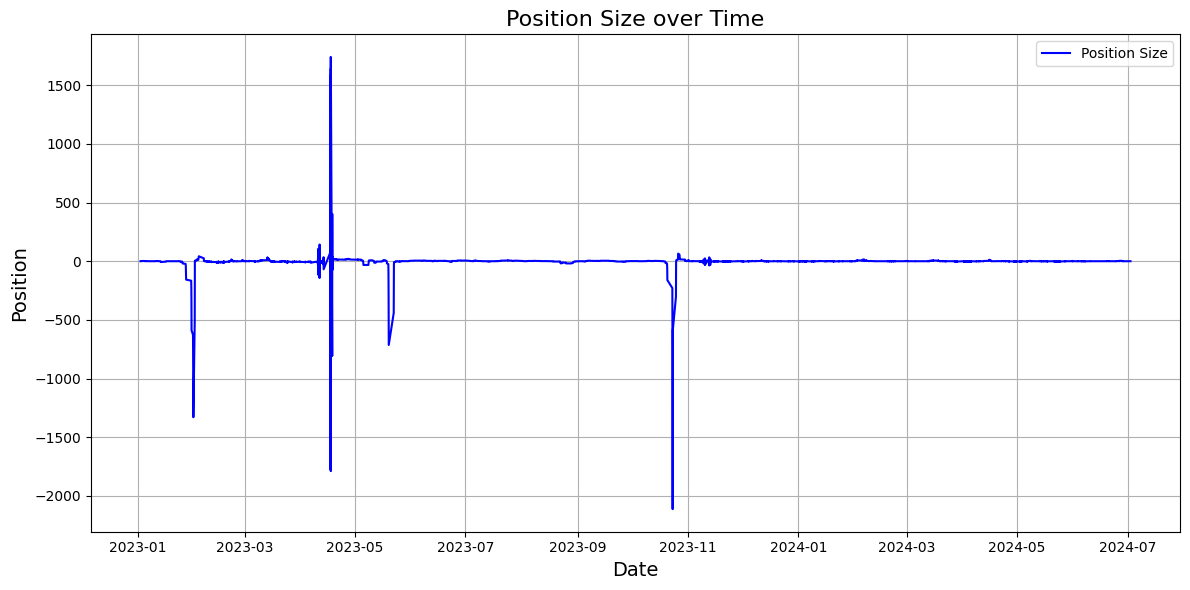

In [ ]:
position_analysis(position_series)

In [ ]:
#Ask about this... surely the forecast will always be so close to 0 with a high price.